In [178]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os
from scipy.signal import savgol_filter  

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc
from joblib import dump
from sklearn.decomposition import PCA

import torchvision.utils as vutils

import torchvision
import shutil

In [179]:
%mkdir data

mkdir: cannot create directory ‘data’: File exists


In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
!unzip /content/drive/MyDrive/cuda/sheet6/data/img_align_celeba.zip -d /content/data

Archive:  /content/drive/MyDrive/cuda/sheet6/data/img_align_celeba.zip
replace /content/data/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!cp /content/drive/MyDrive/cuda/sheet6/data/list_eval_partition.txt /content/data

In [182]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((64, 64)),
#                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((128, 128)),
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

In [183]:
B_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [184]:
class CelebA_Dataset(Dataset):
    def __init__(self, data_dir, split, transform):
        super().__init__()
        self.img_dir = os.path.join(data_dir + "/img_align_celeba")
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.make_split()
    
    def make_split(self):
        partition_list_path = os.path.join(self.data_dir, "list_eval_partition.txt")
        partition_list = np.loadtxt(partition_list_path, dtype=str)
        if self.split == "train":
            self.img_names = partition_list[partition_list[:, 1].astype(float) == 0, 0]
        elif self.split == "test":
            self.img_names = partition_list[partition_list[:, 1].astype(float) > 0, 0]
            
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.img_names)
    
    def t(self, img):
        return self.transform(img)
        
    def __getitem__(self, idx):
        if type(idx) != int:
            file_names = [os.path.join(self.img_dir, self.img_names[id]) for id in idx]
            imgs = []
            for name in file_names:
                img = np.array(Image.open(name))
                if self.transform:
                    img = self.t(img)
                imgs.append(img)
            return np.stack(imgs)
                             
        file_name = os.path.join(self.img_dir, self.img_names[idx])
        img = np.array(Image.open(file_name))
        
        if self.transform:
            img = self.t(img)
    
        return img

In [185]:
train_dataset = CelebA_Dataset("/content/data", "train", t)
test_dataset = CelebA_Dataset("/content/data", "test", test_transform)

In [186]:
len(train_dataset)

162770

In [187]:
train_loader = DataLoader(train_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 64, 64])


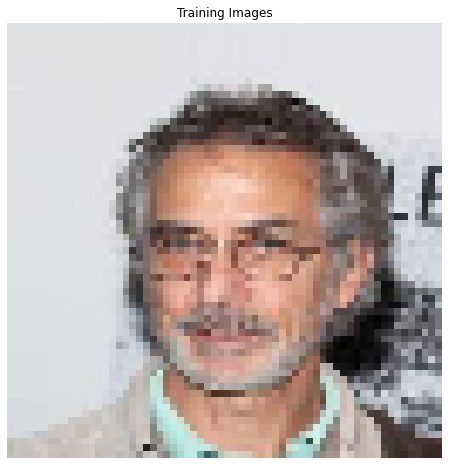

In [188]:
real_batch = next(iter(train_loader))
print(real_batch.size())
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:256], padding=2, normalize=True).cpu(),(1,2,0)))

In [189]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [191]:

nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64


# Beta1 hyperparam for Adam optimizers
beta1 = 0.5



# Learning rate for optimizers
lr = 0.0002

num_epochs = 5

In [195]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        
        return self.main(input)

In [196]:

netG = Generator().to(device)


netG.apply(weights_init)


print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [197]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [198]:

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [200]:
def image_to_vector(img):
    """ Converting images into vectors """
    vector = img.view(img.shape[0], -1)
    return vector 

def vector_to_image(vector, shape=(1,32,32)):
    """ Converting flattened images into matrices """
    images = vector.view(vector.shape[0], *shape)
    return images

In [215]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, latent_dim=128, writer=None):
        """ Initialzer """
        
        
        self.latent_dim = latent_dim
        self.writer = writer 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        generator = Generator().to(device)
        discriminator = Discriminator().to(device)
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=3e-4, betas=(0.0, 0.9))
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=3e-4, betas=(0.0, 0.9))
        
        # alternatively, you can use the BCE loss from PyTorch
        eps = 1e-10
        self.criterion_d_real = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        self.criterion_d_fake = lambda pred: torch.clip(-torch.log(pred + eps), min=-10).mean()
        self.criterion_g = lambda pred: torch.clip(-torch.log(1-pred + eps), min=-10).mean()
        # self.criterion_d_real = lambda pred: F.relu(1-pred).mean()
        # self.criterion_d_fake = lambda pred: F.relu(pred).mean()
        # self.criterion_g = lambda pred: F.relu(1-pred).mean()
        
        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }
        return
        
    def train_one_step(self, imgs):
        """ Training both models for one optimization step """
        
        self.generator.train()
        self.discriminator.train()
        
        # Sample from the latent distribution
        B = imgs.shape[0]
        latent = torch.randn(B, nz,1,1).to(self.device)
        
        # ==== Training Discriminator ====
        self.optim_discriminator.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.discriminator(imgs)
        # Compute the loss function
        d_loss_real = self.criterion_d_real(prediction_real)

        # Generating fake samples with the generator
        fake_samples = self.generator(latent)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.discriminator(fake_samples.detach()) 
        # Compute the loss function
        d_loss_fake = self.criterion_d_fake(prediction_fake_d)
        (d_loss_real + d_loss_fake).backward()
        
        # optimization step
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()
        
        # === Train the generator ===
        self.optim_generator.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.discriminator(fake_samples)
        # Compute the loss function
        g_loss = self.criterion_g(prediction_fake_g)
        g_loss.backward()
        # optimization step
        self.optim_generator.step()
        
        return d_loss_real + d_loss_fake, g_loss
    
    @torch.no_grad()
    def generate(self, N=64):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(N, nz,1,1).to(self.device)
        samples = self.generator(latent)
        #imgs = vector_to_image(samples)
        imgs = samples
        imgs = imgs * 0.5 + 0.5
        return imgs
        
    def train(self, data_loader, N_iters=1, init_step=0):
        """ Training the models for several iterations """
        
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        
        for i in range(N_iters):
          
            for  _ , real_batch in enumerate(data_loader, 0):
                print()
                #real_samples = image_to_vector(real_batch)
                real_samples = real_batch
                real_samples = real_samples.to(self.device)
                d_loss, g_loss = self.train_one_step(imgs=real_samples)
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
               
                if(iter_ % 500 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    
                   

                iter_ = iter_ + 1 
                
        return

In [216]:
trainer = Trainer(latent_dim=128,  writer=None)

In [217]:
trainer.train(data_loader=train_loader)


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------- 0
----------------------------------------- 1


Streaming output truncated to the last 5000 lines.
Ep 1 Iter 103: D_Loss=0.0, G_Loss=23.02585):   0%|          | 0/1 [00:19<?, ?it/s]
Ep 1 Iter 104: D_Loss=0.00025, G_Loss=23.02585):   0%|          | 0/1 [00:19<?, ?it/s]
Ep 1 Iter 5086: D_Loss=0.0, G_Loss=23.02585):   0%|          | 0/1 [15:34<?, ?it/s]
